In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind


## Cookie cats data
Data downloaded from Kaggle on 8 January 2025:
https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats

**Context**

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It is a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase

This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.


**Content**

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

- **userid:** A unique number that identifies each player. 
- **version:** Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- **sum_gamerounds:** the number of game rounds played by the player during the first 14 days after install.
- **retention_1:** Did the player come back and play 1 day after installing?
- **retention_7:** Did the player come back and play 7 days after installing?

**Pause:**
1. Do you have a prior about the impact of making people wait sooner or later in the game?
2. Can you phrase this as a hypothesis?
3. Should we do a one- or a two-tailed test?

### Data inspection and cleaning

In [56]:
# import data
df = pd.read_csv('./data/game/cookie_cats.csv') 

In [57]:
# check column names, data types and potential missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [58]:
# check for duplicate userIDs
df.userid.nunique()

90189

In [59]:
# check distribution of numeric columns, e.g. for outliers
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


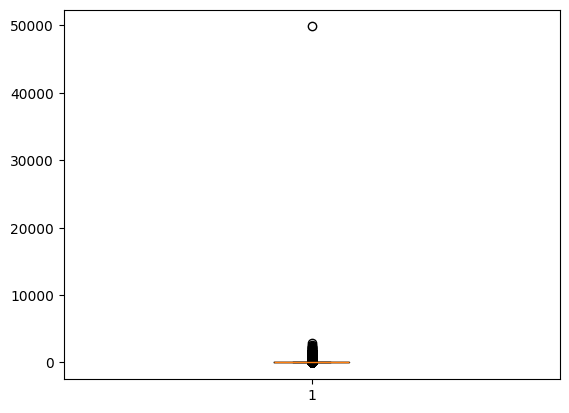

In [60]:
# display distribution to verify outliers
plt.boxplot(df['sum_gamerounds'])
plt.show()

In [61]:
# show the outlier
max_value = df.sum_gamerounds.max()
print(max_value)

df.loc[df['sum_gamerounds']==max_value]

49854


,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


**Pause:**
1. What would you do with this outlier? Justify your decision.
2. Can you also justify the opposite decision?

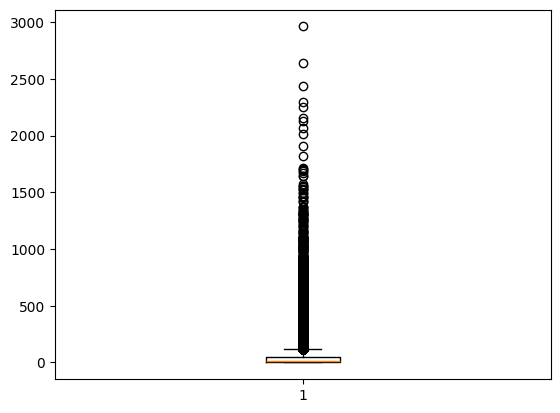

In [62]:
# only keep values below a chosen threshold
df = df.loc[df['sum_gamerounds'] < 40000]

# check distribution again
plt.boxplot(df['sum_gamerounds'])
plt.show()

### Inspecting treatment groups and outcome definitions

In [86]:
# quick way to check distribution of participants across control groups
df.version.value_counts()

version
gate_40    45489
gate_30    44699
Name: count, dtype: int64

In [110]:
# create numeric columns equivalent to boolean (not all operator interpret 'True' as 1)
df['retention_1_num'] = df['retention_1']*1
df['retention_7_num'] = df['retention_7']*1
df.sample(2)

,userid,version,sum_gamerounds,retention_1,retention_7,retention_1_num,retention_7_num
57157,6332749,gate_40,83,True,False,1,0
6995,775710,gate_40,48,False,False,0,0


In [105]:
# create separate data frames for convenience
participants = len(df)

df_late = df.loc[df['version']=='gate_40']
df_early = df.loc[df['version']=='gate_30']

print('Included participants:', participants)
print('Gate_30 (early):', len(df_early),round(len(df_early)/participants*100,2),'%' )
print('Gate_40 (late):', len(df_late),round(len(df_late)/participants*100,2),'%' )

Included participants: 90188
Gate_30 (early): 44699 49.56 %
Gate_40 (late): 45489 50.44 %


**Pause:**
1. In an ideal, what additional data would you like to have about users?
2. What would you do with this data and why?
3. Does the sample look large enough to you? What does this depend on?

#### (1) Game rounds

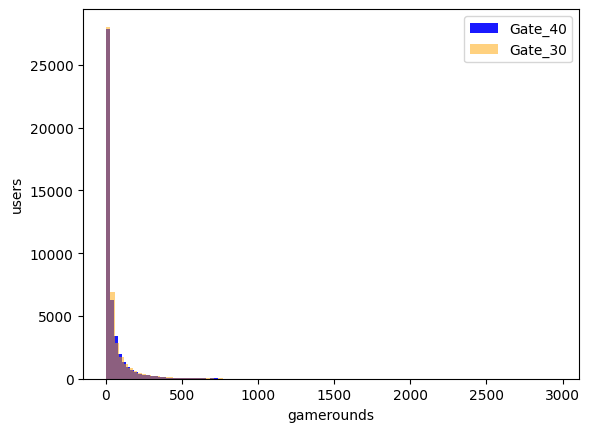

Gate_30 mean gamerounds:  51.3421
Gate_40 mean gamerounds:  51.2988


Difference in means (d): 0.043300000000002115
t-test statistic: -0.0633675766982082
p-value (t-test): 0.9494739458256001


In [121]:
# first outcome definition: number of gamerounds played

# visualise in histogram
plt.hist(df_late['sum_gamerounds'], 100, alpha=0.9, color='blue', label='Gate_40')
plt.hist(df_early['sum_gamerounds'], 100, alpha=0.5, color='orange', label='Gate_30')
plt.legend(loc="upper right")
plt.title("")
plt.xlabel("gamerounds")
plt.ylabel("users")
plt.show()

# compare means
av_gr_late = round(np.mean(df_late['sum_gamerounds']), 4)
av_gr_early = round(np.mean(df_early['sum_gamerounds']), 4)

print('Gate_30 mean gamerounds: ', av_gr_early)
print('Gate_40 mean gamerounds: ', av_gr_late)
print('\n')

# Find the difference from the latest run
diff_gr = av_gr_early - av_gr_late

# Perform a t-test - for independent samples of scores
t_stat, p_value_ttest = ttest_ind(df_late['sum_gamerounds'], df_early['sum_gamerounds'])

# Display results
print(f"Difference in means (d): {diff_gr}")
print(f"t-test statistic: {t_stat}")
print(f"p-value (t-test): {p_value_ttest}")

#### (2) 1-Day return

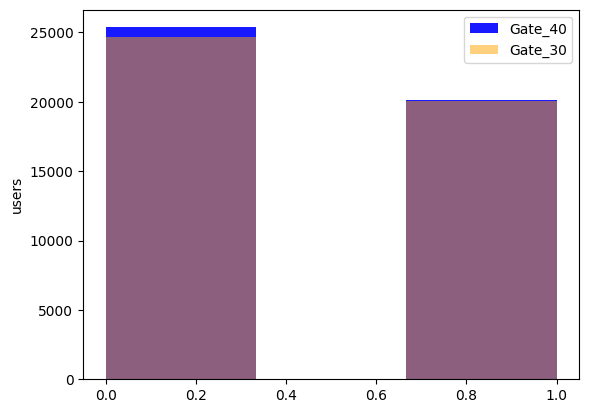

Gate_30 mean retention_1:  0.4482
Gate_40 mean retention_1:  0.4423


Difference in means (d): 0.005899999999999961
t-test statistic: -1.787115337299244
p-value (t-test): 0.07392220630182518


In [122]:
# second outcome definition: likelihood of coming back within one day 

# visualise in histogram
plt.hist(df_late['retention_1_num'], 3, alpha=0.9, color='blue', label='Gate_40')
plt.hist(df_early['retention_1_num'], 3, alpha=0.5, color='orange', label='Gate_30')
plt.legend(loc="upper right")
plt.title("")
plt.xlabel("")
plt.ylabel("users")
plt.show()

# compare means
av_r1_late = round(np.mean(df_late['retention_1_num']), 4)
av_r1_early = round(np.mean(df_early['retention_1_num']), 4)

print('Gate_30 mean retention_1: ', av_r1_early)
print('Gate_40 mean retention_1: ', av_r1_late)
print('\n')

# Find the difference from the latest run
diff_gr = av_r1_early - av_r1_late

# Perform a t-test - for independent samples of scores
t_stat, p_value_ttest = ttest_ind(df_late['retention_1_num'], df_early['retention_1_num'])

# Display results
print(f"Difference in means (d): {diff_gr}")
print(f"t-test statistic: {t_stat}")
print(f"p-value (t-test): {p_value_ttest}")

#### (3) 7-Day return

In [ ]:
# third outcome definition: likelihood of coming back within seven days

#### (4) Continuous engagement

In [ ]:
# fourth outcome definition: likelihood of coming within one day and still being around after seven

## Medical data

Downloaded from Kaggle on 8 January 2025: https://www.kaggle.com/datasets/shashwatwork/clinical-dataset-of-the-cypguides-trial?resource=download

In [123]:
df = pd.read_csv('./data/medical/Dataset.csv')